In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
!pip install pytrials

import requests
import json
from pytrials.client import ClinicalTrials
import os
import re
from requests.exceptions import ChunkedEncodingError, ConnectionError, Timeout
import time
from tqdm import tqdm
import ast

In [3]:
path_reactions = '/content/drive/My Drive/CSV/reactions.csv'
path_reports = '/content/drive/My Drive/CSV/reports.csv'

df_reactions = pd.read_csv(path_reactions)
df_reports = pd.read_csv(path_reports)

In [ ]:
# load all data with alternate drug names
path_acute_myocardial_infarction = '/content/drive/My Drive/CSV/Altdrug/Myocardial_infarction_altdrug.csv'
path_heart_failure = '/content/drive/My Drive/CSV/Altdrug/Heart_failure_altdrug.csv'
path_hypertension = '/content/drive/My Drive/CSV/Altdrug/hypertension_altdrug.csv'
path_ischemic_heart_disease = '/content/drive/My Drive/CSV/Altdrug/ischemic_heart_disease_altdrug.csv'
path_stroke = '/content/drive/My Drive/CSV/Altdrug/stroke_altdrug.csv'
path_COPD = '/content/drive/My Drive/CSV/Altdrug/COPD_altdrug.csv'
path_diabetes = '/content/drive/My Drive/CSV/Altdrug/diabetes_altdrug.csv'
path_asthma = '/content/drive/My Drive/CSV/Altdrug/asthma_altdrug.csv'
path_dementia = '/content/drive/My Drive/CSV/Altdrug/dementia_altdrug.csv'
path_schizophrenia = '/content/drive/My Drive/CSV/Altdrug/schizophrenia_altdrug.csv'
path_epilepsy = '/content/drive/My Drive/CSV/Altdrug/epilepsy_altdrug.csv'
path_multiple_sclerosis = '/content/drive/My Drive/CSV/Altdrug/multiple_sclerosis_altdrug.csv'
path_parkinsonism = '/content/drive/My Drive/CSV/Altdrug/parkinsonism_altdrug.csv'

df_acute_myocardial_infarction = pd.read_csv(path_acute_myocardial_infarction)
df_heart_failure = pd.read_csv(path_heart_failure)
df_hypertension = pd.read_csv(path_hypertension)
df_ischemic_heart_disease = pd.read_csv(path_ischemic_heart_disease)
df_stroke = pd.read_csv(path_stroke)
df_COPD = pd.read_csv(path_COPD)
df_diabetes = pd.read_csv(path_diabetes)
df_asthma = pd.read_csv(path_asthma)
df_dementia = pd.read_csv(path_dementia)
df_schizophrenia = pd.read_csv(path_schizophrenia)
df_epilepsy = pd.read_csv(path_epilepsy)
df_multiple_sclerosis = pd.read_csv(path_multiple_sclerosis)
df_parkinsonism = pd.read_csv(path_parkinsonism)

In [ ]:

diseases = {"Myocardial infarction": df_acute_myocardial_infarction,
               "Heart failure":df_heart_failure,
               "Hypertension": df_hypertension,
               "Ischemic heart disease": df_ischemic_heart_disease,
               "Stroke": df_stroke,
               "Chronic obstructive pulmonary disease": df_COPD,
                "Diabetes": df_diabetes,
                "Asthma": df_asthma,
                "Dementia": df_dementia,
                "Schizophrenia": df_schizophrenia,
                "Epilepsy": df_epilepsy,
                "Multiple sclerosis": df_multiple_sclerosis,
                "Parkinson's": df_parkinsonism
              }
data = []

def get_top_effects(df):
  side_effects = df['PT_NAME_ENG'].value_counts().head(5)
  top_5 = side_effects.index.tolist()
  return top_5


for df in diseases.items():

  # indicate the disease name
  disease = df[0]
  df_merged = pd.merge(df_reports, df[1], on='REPORT_ID', how='inner')
  df_merged = pd.merge(df_merged, df_reactions, on='REPORT_ID', how='inner')
  df_merged["INDICATION_NAME_ENG"] = df_merged["INDICATION_NAME_ENG"].str.upper()

  # find all drug - disease pairs
  for drug in df_merged['Alternate drugname'].unique():
    if isinstance(drug, str) and len(drug.strip()) > 0:
      df_filtered  = df_merged[df_merged['Alternate drugname'] == drug]
      df_female = df_filtered[df_filtered['GENDER_ENG'] == 'Female']
      side_effects_female = get_top_effects(df_female)
      df_male = df_filtered[df_filtered['GENDER_ENG'] == 'Male']
      side_effects_male = get_top_effects(df_male)
      total_women = df_filtered[df_filtered['GENDER_ENG'] == 'Female'].shape[0]
      serious_women_count = df_filtered[(df_filtered['GENDER_ENG'] == 'Female') & (df_filtered['SERIOUSNESS_ENG'] == 'Serious')].shape[0]
      # get proportions
      if total_women > 0:
          percentage_serious_women = round((serious_women_count / total_women) * 100, 2)
      else:
          percentage_serious_women = -1.00

      total_men = df_filtered[df_filtered['GENDER_ENG'] == 'Male'].shape[0]
      serious_men_count = df_filtered[(df_filtered['GENDER_ENG'] == 'Male') & (df_filtered['SERIOUSNESS_ENG'] == 'Serious')].shape[0]
      if total_men > 0:
          percentage_serious_men = round((serious_men_count / total_men) * 100,2)
      else:
        percentage_serious_men = -1.00

      if total_women + total_men > 0:
        percent_women = round(total_women / (total_women + total_men) * 100,2)
        percent_men = round(total_men / (total_women + total_men) * 100,2)

      if total_women + total_men > 10:
        # append data to new dataframe if number of reports higher than 10
        data.append({
            'Drug': drug,
            'Indication': disease.upper(),
            'Total Female Reports': total_women,
            'Total Male Reports': total_men,
            'Percentage Female Reports': percent_women,
            'Percentage Male Reports': percent_men,
            'Percentage Serious Female Reports': percentage_serious_women,
            'Percentage Serious Male Reports': percentage_serious_men,
            'Top 5 Side Effects Female': side_effects_female,
            'Top 5 Side Effects Male': side_effects_male
      })

df_data = pd.DataFrame(data)
pd.set_option('display.width', 500)
print(df_data)

# Specify the directory where you want to save the CSV file
# You can set this to any valid path where you have write permissions
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'disease_pair.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
df_data.to_csv(csv_file_path, index=False)
print(f'Results have been exported to {csv_file_path}')

                                   Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male
0                           CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  [Diarrhoea, Spinal epidural haematoma, Myalgia...  [Off label use, Drug ineffective, Dyspnoea, Pr...
1                            METOPROLOL  MYOCARDIAL INFARCTION                    20                 261                       7.12                    92.88                              95.00                            99.62  [Pleural effusion, Death, Headache, Diarrhoea,...  [Dizziness, Diarrhoea, Fall, Hyponatraemia, Po...
2                  

In [ ]:
path_acute_myocardial_infarction_pairs = '/content/drive/My Drive/CSV/drug_myocardial_infarction_pair.csv'
path_heart_failure_pairs = '/content/drive/My Drive/CSV/drug_heart_failure_pair.csv'
path_hypertension_pairs = '/content/drive/My Drive/CSV/drug_hypertension_pair.csv'
path_ischemic_heart_disease_pairs = '/content/drive/My Drive/CSV/drug_ischemic_heart_disease_pair.csv'
path_stroke_pairs = '/content/drive/My Drive/CSV/drug_stroke_pair.csv'
path_COPD_pairs = '/content/drive/My Drive/CSV/drug_COPD_pair.csv'
path_diabetes_pairs = '/content/drive/My Drive/CSV/drug_diabetes_pair.csv'
path_asthma_pairs = '/content/drive/My Drive/CSV/drug_asthma_pair.csv'
path_dementia_pairs = '/content/drive/My Drive/CSV/drug_dementia_pair.csv'
path_schizophrenia_pairs = '/content/drive/My Drive/CSV/drug_schizophrenia_pair.csv'
path_epilepsy_pairs = '/content/drive/My Drive/CSV/drug_epilepsy_pair.csv'
path_multiple_sclerosis_pairs = '/content/drive/My Drive/CSV/drug_multiple_sclerosis_pair.csv'
path_parkinsonism_pairs = '/content/drive/My Drive/CSV/drug_parkinsonism_pair.csv'

df_acute_myocardial_infarction_pairs = pd.read_csv(path_acute_myocardial_infarction_pairs)
df_heart_failure_pairs = pd.read_csv(path_heart_failure_pairs)
df_hypertension_pairs = pd.read_csv(path_hypertension_pairs)
df_ischemic_heart_disease_pairs = pd.read_csv(path_ischemic_heart_disease_pairs)
df_stroke_pairs = pd.read_csv(path_stroke_pairs)
df_COPD_pairs = pd.read_csv(path_COPD_pairs)
df_diabetes_pairs = pd.read_csv(path_diabetes_pairs)
df_asthma_pairs = pd.read_csv(path_asthma_pairs)
df_dementia_pairs = pd.read_csv(path_dementia_pairs)
df_schizophrenia_pairs = pd.read_csv(path_schizophrenia_pairs)
df_epilepsy_pairs = pd.read_csv(path_epilepsy_pairs)
df_multiple_sclerosis_pairs = pd.read_csv(path_multiple_sclerosis_pairs)
df_parkinsonism_pairs = pd.read_csv(path_parkinsonism_pairs)

df_drug_disease = pd.read_csv('/content/drive/My Drive/CSV/disease_pair.csv')


In [4]:
ctg_studies_path = '/content/drive/My Drive/Data_MedEffect/ctg-studies.csv'
ctg_studies = pd.read_csv(ctg_studies_path)
ctg_studies["Conditions"] = ctg_studies["Conditions"].str.upper()
ctg_studies["Interventions"] = ctg_studies["Interventions"].str.upper()

ctg_studies["Conditions"] = ctg_studies["Conditions"].fillna('').astype(str)
ctg_studies["Interventions"] = ctg_studies["Interventions"].fillna('').astype(str)

In [ ]:
 # get study ids related to each drug and disease as the search
def get_study_ids(drug, disease, df):
    # Filter rows based on drug
    # drug_mask = df["Interventions"].str.contains(drug, case=False, na=False)
    # # Filter rows based on disease
    # disease_mask = df["Conditions"].str.contains(disease, case=False, na=False)
    drug_regex = re.compile(re.escape(drug.strip()), re.IGNORECASE)
    disease_regex = re.compile(re.escape(disease.strip()), re.IGNORECASE)

    # Filter rows based on drug using regex
    drug_mask = df["Interventions"].apply(lambda x: bool(drug_regex.search(str(x))) if pd.notna(x) else False)
    # Filter rows based on disease using regex
    disease_mask = df["Conditions"].apply(lambda x: bool(disease_regex.search(str(x))) if pd.notna(x) else False)
    # Combine both masks
    combined_mask = drug_mask & disease_mask
    # Get study IDs for the filtered rows
    return df[combined_mask]['NCT Number'].tolist()

tqdm.pandas()
curr_df = df_drug_disease
#change df names here
curr_df['NCT Numbers'] = curr_df.progress_apply(lambda row: get_study_ids(row['Drug'], row['Indication'], ctg_studies), axis=1)
print(curr_df)
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file, CHANGE SAVE NAME
csv_file_path = os.path.join(save_directory, 'drug_disease_pair_studies.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
curr_df.to_csv(csv_file_path, index=False)
print(f'Results have been exported to {csv_file_path}')


100%|██████████| 1569/1569 [50:21<00:00,  1.93s/it]

                                   Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male                                        NCT Numbers
0                           CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  [NCT02233790, NCT00684203, NCT00623623, NCT046...
1                            METOPROLOL  MYOCARDIAL INFARCTION                    20                 261                       7.12                    92.88                              95.00                            99.62  ['Pleural effusion

In [ ]:
# concatenate all files together
file_names = ['drug_myocardial_infarction_pair_studies.csv',
              'drug_heart_failure_pair_studies.csv',
              'drug_hypertension_pair_studies.csv',
              'drug_ischemic_heart_disease_pair_studies.csv',
              'drug_stroke_pair_studies.csv',
              'drug_COPD_pair_studies.csv',
              'drug_diabetes_pair_studies.csv',
              'drug_asthma_pair_studies.csv',
              'drug_dementia_pair_studies.csv',
              'drug_schizophrenia_pair_studies.csv',
              'drug_epilepsy_pair_studies.csv',
              'drug_multiple_sclerosis_pair_studies.csv',
              'drug_parkinsonism_pair_studies.csv'
              ]

save_directory = '/content/drive/My Drive/CSV'
output_file = os.path.join(save_directory, 'combined_drug_disease_studies.csv')

# List to store DataFrames
df_list = []

# Iterate over the list of filenames and read each CSV into a DataFrame
for file_name in file_names:
    file_path = os.path.join(save_directory, file_name)
    if os.path.exists(file_path):
        df_chunk = pd.read_csv(file_path)
        df_list.append(df_chunk)
        print(f"Processed {file_name}")
    else:
        print(f"File {file_name} does not exist in the directory {save_directory}")

# Concatenate all DataFrames in the list
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)

    # Save the combined DataFrame to a single CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"All files combined and saved to {output_file}")
else:
    print("No files were found to combine.")

Processed drug_myocardial_infarction_pair_studies.csv
Processed drug_heart_failure_pair_studies.csv
Processed drug_hypertension_pair_studies.csv
Processed drug_ischemic_heart_disease_pair_studies.csv
Processed drug_stroke_pair_studies.csv
Processed drug_COPD_pair_studies.csv
Processed drug_diabetes_pair_studies.csv
Processed drug_asthma_pair_studies.csv
Processed drug_dementia_pair_studies.csv
Processed drug_schizophrenia_pair_studies.csv
Processed drug_epilepsy_pair_studies.csv
Processed drug_multiple_sclerosis_pair_studies.csv
Processed drug_parkinsonism_pair_studies.csv
All files combined and saved to /content/drive/My Drive/CSV/combined_drug_disease_studies.csv


In [14]:
# Initialize ClinicalTrials client
ct = ClinicalTrials()
api_url = 'https://clinicaltrials.gov/api/v2/studies/'

# get data associated with studies

path_combined_pairs = '/content/drive/My Drive/CSV/drug_disease_pair_studies.csv'
df_data = pd.read_csv(path_combined_pairs)
print(df_data)

def fetch_data_with_retries(url, max_retries=3, backoff_factor=0.3):
    for retry in range(max_retries):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for HTTP errors
            return response.json()
        except (ChunkedEncodingError, ConnectionError, Timeout) as e:
            if retry < max_retries - 1:
                time.sleep(backoff_factor * (2 ** retry))  # Exponential backoff
            else:
                raise
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            raise

df_data['Num Studies'] = pd.Series(dtype='int')
df_data['Total females in studies'] = pd.Series(dtype='int')
df_data['Total males in studies'] = pd.Series(dtype='int')
df_data['Female proportion in studies'] = pd.Series(dtype='float')
df_data['Male proportion in studies'] = pd.Series(dtype='float')

study_data = []
for index, row in df_data.iterrows():
    drug = row['Drug']
    indication = row['Indication']
    list_NCT = ast.literal_eval(row['NCT Numbers'])

    num_studies = len(list_NCT)
    df_data.at[index, 'Num Studies'] = int(num_studies)

    tot_num_females = 0
    tot_num_males = 0
    for study_id in list_NCT:
        try:
            female_count = 0
            male_count = 0
            file_path = f"/content/drive/My Drive/StudyResults/{study_id}.json"
            if os.path.exists(file_path):
              with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            else:
              data = fetch_data_with_retries(api_url + study_id)

              if data.get("hasResults", False):
                  # Initialize counters for female and male participants
                  file_save_dir = "/content/drive/My Drive/StudyResults"
                  study_path = os.path.join(file_save_dir, f"{study_id}.json")
                  with open(study_path, 'w') as json_file:
                      json.dump(data, json_file)


            # Parse the JSON data to count the participants
            if "resultsSection" in data and "baselineCharacteristicsModule" in data["resultsSection"]:
              for measure in data["resultsSection"]["baselineCharacteristicsModule"]["measures"]:
                  if measure["title"] == "Sex: Female, Male":
                      for category in measure["classes"][0]["categories"]:
                          if category["title"] == "Female":
                              female_values = []
                              if "measurements" in category:
                                  for measurement in category["measurements"]:
                                      if measurement["value"].replace('.', '', 1).isdigit():
                                          female_values.append(int(float(measurement["value"])))
                              female_count = sum(female_values)
                          elif category["title"] == "Male":
                              male_values = []
                              if "measurements" in category:
                                  for measurement in category["measurements"]:
                                      if measurement["value"].replace('.', '', 1).isdigit():
                                          male_values.append(int(float(measurement["value"])))
                              male_count = sum(male_values)
              study_data.append({
                  'Study NCT': study_id,
                  'Number of participants': female_count + male_count,
                  'Number of female participants': female_count,
                  'Number of male participants': male_count
              })
              tot_num_females += female_count
              tot_num_males += male_count
        except Exception as e:
            print(f"Failed to fetch data for study ID {study_id}: {e}")

    total_num_participants = tot_num_females + tot_num_males
    if total_num_participants > 0:
        # Calculate proportions
        female_proportion = round((tot_num_females / total_num_participants) * 100, 2)
        male_proportion = round((tot_num_males / total_num_participants) * 100, 2)
    else:
        female_proportion = -1.00
        male_proportion = -1.00

    # Update DataFrame
    df_data.at[index, 'Total females in studies'] = int(tot_num_females)
    df_data.at[index, 'Total males in studies'] = int(tot_num_males)
    df_data.at[index, 'Female proportion in studies'] = female_proportion
    df_data.at[index, 'Male proportion in studies'] = male_proportion

df_data = df_data[df_data["Num Studies"]>= 3]
df_data = df_data[(df_data["Total females in studies"] + df_data["Total males in studies"]) >= 20]
print(df_data)

save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'combined_study_results.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
df_data.to_csv(csv_file_path, index=False)

df_study_data = pd.DataFrame(study_data)
df_study_data = df_study_data.drop_duplicates(subset=['Study NCT'], keep='first')
print(df_study_data)
study_data_path = os.path.join(save_directory, 'study_data.csv')
df_study_data.to_csv(study_data_path, index=False)

                                   Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male                                        NCT Numbers
0                           CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  ['NCT02233790', 'NCT00684203', 'NCT00623623', ...
1                            METOPROLOL  MYOCARDIAL INFARCTION                    20                 261                       7.12                    92.88                              95.00                            99.62  ['Pleural effusion

In [15]:
path_combined = '/content/drive/My Drive/CSV/combined_study_results.csv'
combined_df = pd.read_csv(path_combined)
path_study_df = '/content/drive/My Drive/CSV/study_data.csv'
df_study_data = pd.read_csv(path_study_df)

# sort the studies in order of importance, by number of participants, return top 3 studies for each drug disease pair
def sort(studies_list, studies_data):
  studies_list = ast.literal_eval(studies_list)
  df_sorted = df_study_data[df_study_data['Study NCT'].isin(studies_list)]
  print(df_sorted)
  df_sorted = df_sorted.sort_values(by='Number of participants', ascending=False)
  print(df_sorted)
  top_3 = df_sorted.head(3)['Study NCT'].tolist()
  sum_females =  df_sorted.head(3)['Number of female participants'].sum()
  total_females = df_sorted['Number of female participants'].sum()
  print(total_females)
  total_males = df_sorted['Number of male participants'].sum()
  print(total_males)
  sum_males = df_sorted.head(3)['Number of male participants'].sum()
  total_participants = df_sorted.head(3)['Number of participants'].sum()
  if total_participants > 0:
    female_proportion = sum_females/total_participants * 100
    male_proportion = sum_males/total_participants * 100
  else:
    female_proportion = -1.00
    male_proportion = -1.00

  return (top_3, total_participants, sum_females, sum_males, female_proportion, male_proportion)

tqdm.pandas()
result = combined_df['NCT Numbers'].progress_apply(lambda x: sort(x, df_study_data))

# Assign the results to new columns in combined_df
combined_df[[
    "Most relevant studies",
    'Number of participants in most relevant studies',
    'Number of female participants in most relevant studies',
    'Number of male participants in most relevant studies',
    'Proportion of females in most relevant studies',
    'Proportion of males in most relevant studies'
]] = pd.DataFrame(result.tolist(), index=combined_df.index)

save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'combined_study_results_top_3.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
combined_df.to_csv(csv_file_path, index=False)


  4%|▍         | 12/284 [00:00<00:04, 56.65it/s]

      Study NCT  Number of participants  Number of female participants  Number of male participants
0   NCT00684203                     234                             58                          176
1   NCT00623623                    3794                            806                         2988
2   NCT02224274                      72                             12                           60
3   NCT01586975                     186                            102                           84
4   NCT03161678                     178                             90                           88
5   NCT02931045                     120                             28                           92
6   NCT01235351                     666                            168                          498
7   NCT03207451                     162                             46                          116
8   NCT02548650                     128                             36                           92


  6%|▋         | 18/284 [00:00<00:05, 52.81it/s]

      Study NCT  Number of participants  Number of female participants  Number of male participants
19  NCT02924727                   11322                           2726                         8596
      Study NCT  Number of participants  Number of female participants  Number of male participants
19  NCT02924727                   11322                           2726                         8596
2726
8596
      Study NCT  Number of participants  Number of female participants  Number of male participants
33  NCT03746002                       6                              2                            4
34  NCT02877095                      80                             24                           56
35  NCT02183792                      66                             16                           50
36  NCT01901809                     180                            122                           58
37  NCT00904488                      22                             10                    

  8%|▊         | 24/284 [00:00<00:07, 35.49it/s]


      Study NCT  Number of participants  Number of female participants  Number of male participants
50  NCT00391846                     504                            144                          360
59  NCT02970669                     280                             64                          216
60  NCT02874794                     928                            218                          710
61  NCT03300427                     110                             24                           86
62  NCT03988634                     932                            484                          448
63  NCT02816736                     730                            206                          524
64  NCT03552575                     186                             16                          170
65  NCT01920711                    9644                           4982                         4662
66  NCT02887183                     794                            226                          568

 10%|█         | 29/284 [00:00<00:07, 33.02it/s]

      Study NCT  Number of participants  Number of female participants  Number of male participants
57  NCT01178528                       0                              0                            0
95  NCT02247245                      80                             20                           60
96  NCT02441218                   13010                           3070                         9940
97  NCT02827500                     208                             74                          134
98  NCT03456856                      30                              9                           21
      Study NCT  Number of participants  Number of female participants  Number of male participants
96  NCT02441218                   13010                           3070                         9940
97  NCT02827500                     208                             74                          134
95  NCT02247245                      80                             20                           60


 13%|█▎        | 37/284 [00:01<00:07, 31.25it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
116  NCT02111564                   24038                          11470                        12568
115  NCT01877915                   10044                           2300                         7744
13770
20312
       Study NCT  Number of participants  Number of female participants  Number of male participants
117  NCT00181155                      13                              4                            9
118  NCT04327024                     318                            112                          206
119  NCT00987415                     506                             90                          416
       Study NCT  Number of participants  Number of female participants  Number of male participants
119  NCT00987415                     506                             90                          416
118  NCT04327024                     318                            112        

 16%|█▌        | 46/284 [00:01<00:06, 36.10it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
70   NCT00149227                    6062                           2606                         3456
129  NCT02480764                    1224                            520                          704
130  NCT00439738                     824                            544                          280
131  NCT01353508                      64                             18                           46
132  NCT01365481                     300                            102                          198
133  NCT00698646                     768                            428                          340
134  NCT01001572                    1302                            582                          720
135  NCT00902304                    3124                           1198                         1926
136  NCT00523744                       0                              0                    

 18%|█▊        | 50/284 [00:01<00:06, 34.02it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
309  NCT00348686                     315                             81                          234
310  NCT02336607                     962                            430                          532
       Study NCT  Number of participants  Number of female participants  Number of male participants
310  NCT02336607                     962                            430                          532
309  NCT00348686                     315                             81                          234
511
766
       Study NCT  Number of participants  Number of female participants  Number of male participants
149  NCT00661895                     198                            144                           54
173  NCT00582114                     400                            138                          262
210  NCT01658657                      34                             14            

 21%|██        | 59/284 [00:01<00:06, 36.60it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
149  NCT00661895                     198                            144                           54
341  NCT03109795                       0                              0                            0
342  NCT01983462                      66                             16                           50
343  NCT01297335                      10                              8                            2
       Study NCT  Number of participants  Number of female participants  Number of male participants
149  NCT00661895                     198                            144                           54
342  NCT01983462                      66                             16                           50
343  NCT01297335                      10                              8                            2
341  NCT03109795                       0                              0                    

 24%|██▎       | 67/284 [00:01<00:05, 36.46it/s]


68
       Study NCT  Number of participants  Number of female participants  Number of male participants
113  NCT01726049                     104                             74                           30
114  NCT02304705                      66                             26                           40
366  NCT01044693                      20                              6                           14
382  NCT00946114                      64                             52                           12
383  NCT00796510                       6                              4                            2
384  NCT01392469                      21                             15                            6
385  NCT00433329                     100                             82                           18
386  NCT01244620                      16                              0                           16
387  NCT01601470                      28                              0                

 26%|██▋       | 75/284 [00:01<00:04, 43.89it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
450  NCT03961360                     440                            440                            0
451  NCT00384865                     128                            110                           18
449  NCT04402385                      78                             78                            0
628
18
       Study NCT  Number of participants  Number of female participants  Number of male participants
294  NCT01371747                     608                            224                          384
452  NCT01897727                      32                             12                           20
453  NCT02236520                     118                             80                           38
454  NCT02194465                     606                            226                          380
455  NCT01062763                     238                             56             

 30%|██▉       | 85/284 [00:02<00:04, 41.00it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
247  NCT00923091                    5378                           2886                         2492
244  NCT00649389                    4984                           2348                         2636
419  NCT00846365                    2170                           1044                         1126
433  NCT01033071                    2142                            884                         1258
427  NCT00430950                    2020                            790                         1230
426  NCT00430508                    1942                            744                         1198
296  NCT00949884                    1882                            856                         1026
417  NCT00996281                    1674                            730                          944
237  NCT00902538                    1616                            678                    

 35%|███▍      | 99/284 [00:02<00:03, 54.51it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
524  NCT01178073                    1210                            922                          288
531  NCT00549302                     714                            556                          158
454  NCT02194465                     606                            226                          380
532  NCT02558231                     494                            374                          120
395  NCT02891850                     450                            354                           96
530  NCT03904693                     372                            290                           82
533  NCT02688387                     224                              2                          222
391  NCT00617305                      76                             56                           20
527  NCT01862536                      72                              0                    

 40%|████      | 114/284 [00:02<00:03, 55.55it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
581  NCT01120691                    4412                           1110                         3302
586  NCT01613326                    1314                            344                          970
614  NCT03256695                     405                            220                          185
615  NCT01857323                     317                            178                          139
587  NCT01490125                     246                             73                          173
616  NCT01833026                     112                             78                           34
2003
4803
       Study NCT  Number of participants  Number of female participants  Number of male participants
617  NCT01658020                     684                             60                          624
       Study NCT  Number of participants  Number of female participants  Number o

 42%|████▏     | 120/284 [00:02<00:03, 51.60it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
660  NCT00123643                      72                             34                           38
661  NCT00232583                     116                             42                           74
662  NCT01029795                      76                             26                           50
663  NCT00286468                    1000                            478                          522
664  NCT00965991                     298                            298                            0
665  NCT00744965                     750                            750                            0
666  NCT00194896                     128                             36                           92
667  NCT00313313                    1536                            844                          692
       Study NCT  Number of participants  Number of female participants  Number of male par

 44%|████▍     | 126/284 [00:03<00:03, 45.24it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
963   NCT01709305                    5535                           2240                         3295
1091  NCT01590771                     996                            498                          498
1365  NCT01022762                     870                            404                          466
1066  NCT01076075                     844                            458                          386
852   NCT00367055                     168                             54                          114
1367  NCT02682563                      88                             20                           68
939   NCT00780715                      58                             28                           30
1231  NCT01991197                      40                              8                           32
1366  NCT04198948                      30                              0          

 49%|████▉     | 139/284 [00:03<00:02, 49.84it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
1408  NCT02586155                    4836                           1236                         3600
1375  NCT00862251                    1616                            772                          844
1406  NCT00747149                    1196                            590                          606
1409  NCT00296374                     706                            216                          490
1405  NCT03074630                      11                              2                            9
1407  NCT01544309                       0                              0                            0
2816
5549
        Study NCT  Number of participants  Number of female participants  Number of male participants
669   NCT00611884                     490                            216                          274
674   NCT03952143                    1190                            550

 51%|█████     | 145/284 [00:03<00:03, 43.52it/s]


        Study NCT  Number of participants  Number of female participants  Number of male participants
840   NCT01106690                     684                            252                          432
879   NCT03267576                     126                             56                           70
883   NCT01809327                    2372                           1234                         1138
949   NCT04288778                     274                            106                          168
966   NCT01106677                    2568                           1358                         1210
984   NCT01340664                     558                            298                          260
998   NCT00968812                       0                              0                            0
999   NCT01137812                    1510                            666                          844
1038  NCT01106625                     938                            460         

 55%|█████▍    | 155/284 [00:03<00:03, 39.26it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
1699  NCT01541735                      28                             22                            6
1234  NCT00768651                       8                              1                            7
23
13
        Study NCT  Number of participants  Number of female participants  Number of male participants
1123  NCT01488279                      20                             12                            8
1700  NCT01673191                      74                             40                           34
        Study NCT  Number of participants  Number of female participants  Number of male participants
1700  NCT01673191                      74                             40                           34
1123  NCT01488279                      20                             12                            8
52
42
        Study NCT  Number of participants  Number of female participan

 56%|█████▋    | 160/284 [00:03<00:03, 35.86it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
1765  NCT01328964                   19812                           7922                        11890
1802  NCT00337675                    3542                           1406                         2136
1785  NCT00461032                    2324                            922                         1402
1786  NCT00284856                    2038                            952                         1086
1770  NCT01147744                    1400                           1288                          112
1796  NCT00968201                    1378                            572                          806
1808  NCT00911547                    1284                            624                          660
1792  NCT01656395                    1152                            596                          556
1768  NCT00394355                    1132                            718          

 59%|█████▉    | 168/284 [00:04<00:03, 36.21it/s]


546
        Study NCT  Number of participants  Number of female participants  Number of male participants
626   NCT01554488                      50                             22                           28
1765  NCT01328964                   19812                           7922                        11890
1768  NCT00394355                    1132                            718                          414
1770  NCT01147744                    1400                           1288                          112
1772  NCT00296491                       0                              0                            0
1775  NCT00127166                     308                            130                          178
1777  NCT00712335                     210                            112                           98
1779  NCT01606306                     600                            242                          358
1795  NCT00395304                     182                             63     

 65%|██████▍   | 184/284 [00:04<00:01, 56.03it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
1872  NCT01576718                    1280                            758                          522
1848  NCT01479621                    1244                            716                          528
1918  NCT01967173                    1148                            618                          530
1911  NCT02251379                     310                            122                          188
1871  NCT01907334                      10                              3                            7
1941  NCT00716963                       7                              4                            3
2221
1778
        Study NCT  Number of participants  Number of female participants  Number of male participants
1763  NCT00702325                     602                            392                          210
1765  NCT01328964                   19812                           7922

 67%|██████▋   | 190/284 [00:04<00:02, 45.99it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
1935  NCT01347060                   34896                          21766                        13130
1937  NCT01332357                    6139                           3392                         2747
1969  NCT02301975                    3008                           1928                         1080
1974  NCT02980133                    1682                            648                         1034
1930  NCT00424008                    1444                            918                          526
1875  NCT04677959                     854                            586                          268
1936  NCT00353873                     606                            216                          390
1954  NCT03207243                     330                            236                           94
1933  NCT00557440                      74                             30          

 69%|██████▉   | 196/284 [00:04<00:02, 40.45it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
1998  NCT03158311                    2852                           1804                         1048
2004  NCT03063086                     116                             55                           61
2008  NCT02571777                    6184                           3836                         2348
2150  NCT03108027                      37                             16                           21
2151  NCT03100825                      94                             44                           50
        Study NCT  Number of participants  Number of female participants  Number of male participants
2008  NCT02571777                    6184                           3836                         2348
1998  NCT03158311                    2852                           1804                         1048
2004  NCT03063086                     116                             55          

 73%|███████▎  | 207/284 [00:04<00:01, 43.27it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2174  NCT00768261                     204                            110                           94
2180  NCT00545974                     162                             60                          102
2181  NCT02553928                     124                             68                           56
2182  NCT00322153                    1352                            974                          378
2183  NCT00294554                      40                              6                           34
2184  NCT02118727                     178                             74                          104
        Study NCT  Number of participants  Number of female participants  Number of male participants
2182  NCT00322153                    1352                            974                          378
2174  NCT00768261                     204                            110          

 75%|███████▍  | 212/284 [00:05<00:02, 34.13it/s]


        Study NCT  Number of participants  Number of female participants  Number of male participants
2264  NCT02404155                     274                            106                          168
2262  NCT00981526                     108                             54                           54
2239  NCT01639872                      94                             10                           84
2265  NCT00042224                      78                             36                           42
2263  NCT00498550                      62                             14                           48
2266  NCT00001656                      50                             20                           30
2261  NCT00573287                      28                             12                           16
252
442
        Study NCT  Number of participants  Number of female participants  Number of male participants
2189  NCT03230864                     238                            110 

 76%|███████▌  | 216/284 [00:05<00:02, 28.44it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2305  NCT00531518                     584                            230                          354
        Study NCT  Number of participants  Number of female participants  Number of male participants
2305  NCT00531518                     584                            230                          354
230
354
        Study NCT  Number of participants  Number of female participants  Number of male participants
2273  NCT01617187                     714                            296                          418
2275  NCT00265343                     612                            192                          420
2283  NCT00174265                     390                             90                          300
2284  NCT00145496                     936                            244                          692
2354  NCT00156065                     370                            168  

 77%|███████▋  | 220/284 [00:05<00:02, 23.97it/s]


380
        Study NCT  Number of participants  Number of female participants  Number of male participants
2219  NCT02002832                     768                            370                          398
2227  NCT00641745                       0                              0                            0
2238  NCT00711269                     894                            366                          528
2244  NCT03557931                     466                            140                          326
2290  NCT00615433                     950                            208                          742
2293  NCT00790192                       0                              0                            0
2297  NCT00789698                     584                            194                          390
2353  NCT00044044                     706                            182                          524
2355  NCT02199743                      48                             22     

 80%|███████▉  | 226/284 [00:06<00:02, 20.15it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2427  NCT01041274                     190                             70                          120
2428  NCT01032083                     124                             28                           96
        Study NCT  Number of participants  Number of female participants  Number of male participants
2427  NCT01041274                     190                             70                          120
2428  NCT01032083                     124                             28                           96
98
216
        Study NCT  Number of participants  Number of female participants  Number of male participants
2244  NCT03557931                     466                            140                          326
2299  NCT01810380                     928                            400                          528
2307  NCT02054702                     194                             56   

 82%|████████▏ | 232/284 [00:06<00:02, 22.43it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2232  NCT00206102                    2196                            904                         1292
2292  NCT00642369                     120                             74                           46
2295  NCT00852631                      28                              8                           20
2298  NCT00640601                     295                            113                          182
2301  NCT00882518                     768                            404                          364
2302  NCT01213836                       0                              0                            0
2303  NCT00779506                      89                             37                           52
2304  NCT00227305                     380                            154                          226
        Study NCT  Number of participants  Number of female participants  Number o

 86%|████████▌ | 244/284 [00:06<00:01, 38.64it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2474  NCT02565108                      40                             20                           20
2475  NCT00162981                     136                             52                           84
2476  NCT00518713                     476                            188                          288
2477  NCT02564952                      18                              8                           10
2478  NCT03371836                      20                             16                            4
        Study NCT  Number of participants  Number of female participants  Number of male participants
2476  NCT00518713                     476                            188                          288
2475  NCT00162981                     136                             52                           84
2474  NCT02565108                      40                             20          

 92%|█████████▏| 261/284 [00:06<00:00, 58.57it/s]


13897
6662
        Study NCT  Number of participants  Number of female participants  Number of male participants
2599  NCT01058005                     150                            118                           32
2602  NCT00811395                     478                            356                          122
2603  NCT01534182                     596                            424                          172
2604  NCT00475865                     246                            194                           52
2605  NCT01578785                     356                            264                           92
2606  NCT01569451                     106                             74                           32
2607  NCT00451451                    2834                           1986                          848
2608  NCT00211887                    2016                           1460                          556
2609  NCT00337779                    2310                           16

 98%|█████████▊| 279/284 [00:06<00:00, 74.01it/s]


48
        Study NCT  Number of participants  Number of female participants  Number of male participants
2617  NCT04878211                      48                             38                           10
2708  NCT02792218                    1854                           1270                          584
2731  NCT04667117                     126                             96                           30
2732  NCT03249714                     128                            110                           18
2733  NCT03560739                     568                            398                          170
2734  NCT01457924                     462                            310                          152
2735  NCT00640328                      76                             44                           32
        Study NCT  Number of participants  Number of female participants  Number of male participants
2708  NCT02792218                    1854                           1270      

100%|██████████| 284/284 [00:06<00:00, 40.78it/s]


        Study NCT  Number of participants  Number of female participants  Number of male participants
2815  NCT00623363                      50                             12                           38
        Study NCT  Number of participants  Number of female participants  Number of male participants
2815  NCT00623363                      50                             12                           38
12
38


In [13]:
pd.set_option('display.width', 500)
print(combined_df)
print(combined_df['NCT Numbers'][1])
sorted = sort(combined_df['NCT Numbers'][1], df_study_data)
print(sorted)

             Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male  ... Total females in studies  Total males in studies  Female proportion in studies  Male proportion in studies                    Most relevant studies  \
0     CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  ...                  10918.0                 30130.0                         26.60                       73.40  [NCT00305162, NCT00257309, NCT00623623]   
1    TENECTEPLASE  MYOCARDIAL INFARCTION                    57                

In [17]:
path_acute_myocardial_infarction_CCDSS= '/content/drive/My Drive/CCDSS/acute_myocardial_infarction_CCDSS.csv'
path_heart_failure_CCDSS= '/content/drive/My Drive/CCDSS/heart_failure_CCDSS.csv'
path_hypertension_CCDSS= '/content/drive/My Drive/CCDSS/hypertension_CCDSS.csv'
path_ischemic_heart_disease_CCDSS= '/content/drive/My Drive/CCDSS/ischemic_heart_disease_CCDSS.csv'
path_stroke_CCDSS= '/content/drive/My Drive/CCDSS/stroke_CCDSS.csv'
path_COPD_CCDSS = '/content/drive/My Drive/CCDSS/chronic_obstructive_pulmonary_CCDSS.csv'
path_diabetes_CCDSS = '/content/drive/My Drive/CCDSS/diabetes_CCDSS.csv'
path_asthma_CCDSS ='/content/drive/My Drive/CCDSS/asthma_CCDSS.csv'
path_dementia_CCDSS = '/content/drive/My Drive/CCDSS/dementia_CCDSS.csv'
path_schizophrenia_CCDSS ='/content/drive/My Drive/CCDSS/schizophrenia_CCDSS.csv'
path_epilepsy_CCDSS = '/content/drive/My Drive/CCDSS/epilepsy_CCDSS.csv'
path_multiple_sclerosis_CCDSS = '/content/drive/My Drive/CCDSS/multiple_sclerosis_CCDSS.csv'
path_parkinsonism_CCDSS = '/content/drive/My Drive/CCDSS/parkinsonism_CCDSS.csv'

acute_myocardial_infarction_CCDSS = pd.read_csv(path_acute_myocardial_infarction_CCDSS, skiprows=1, encoding="latin1")
heart_failure_CCDSS = pd.read_csv(path_heart_failure_CCDSS, skiprows=1,encoding="latin1")
hypertension_CCDSS = pd.read_csv(path_hypertension_CCDSS,skiprows=1, encoding="latin1")
ischemic_heart_disease_CCDSS = pd.read_csv(path_ischemic_heart_disease_CCDSS,skiprows=1, encoding="latin1")
stroke_CCDSS = pd.read_csv(path_stroke_CCDSS, skiprows=1,encoding="latin1")
COPD_CCDSS = pd.read_csv(path_COPD_CCDSS, skiprows=1,encoding="latin1")
diabetes_CCDSS = pd.read_csv(path_diabetes_CCDSS, skiprows=1,encoding="latin1")
asthma_CCDSS = pd.read_csv(path_asthma_CCDSS, skiprows=1,encoding="latin1")
dementia_CCDSS = pd.read_csv(path_dementia_CCDSS, skiprows=1,encoding="latin1")
schizophrenia_CCDSS =pd.read_csv(path_schizophrenia_CCDSS, skiprows=1,encoding="latin1")
epilepsy_CCDSS = pd.read_csv(path_epilepsy_CCDSS, skiprows=1,encoding="latin1")
multiple_sclerosis_CCDSS = pd.read_csv(path_multiple_sclerosis_CCDSS, skiprows=1,encoding="latin1")
parkinsonism_CCDSS = pd.read_csv(path_parkinsonism_CCDSS, skiprows=1,encoding="latin1")
print(heart_failure_CCDSS)


                                            Geography         Sex Age group type Age group Fiscal year  Prevalence (%)  Standard Error  Lower 95%_CI  Upper 95%_CI  Rate CV (%)    Counts  Population  Unnamed: 12
0                                              Canada  Both sexes          Total       40+   20002001            3.37            0.01          3.36          3.38         0.15  457925.0  14122655.0          NaN
1                                              Canada     Females          Total       40+   20002001            2.94            0.01          2.92          2.95         0.21  238580.0   7352470.0          NaN
2                                              Canada       Males          Total       40+   20002001            3.90            0.01          3.89          3.92         0.22  219345.0   6770180.0          NaN
3                                              Canada  Both sexes          Total       40+   20012002            3.48            0.01          3.47        

In [18]:
path_combined = '/content/drive/My Drive/CSV/combined_study_results_top_3.csv'
data_df = pd.read_csv(path_combined)

# get prevalence data per type of disease
prevalence_acute_myocardial_infarction = acute_myocardial_infarction_CCDSS.groupby("Sex")[acute_myocardial_infarction_CCDSS.columns[5]].mean()
prevalence_heart_failure = heart_failure_CCDSS.groupby("Sex")[heart_failure_CCDSS.columns[5]].mean()
prevalence_hypertension = hypertension_CCDSS.groupby("Sex")[hypertension_CCDSS.columns[5]].mean()
prevalence_ischemic_heart_disease = ischemic_heart_disease_CCDSS.groupby("Sex")[ischemic_heart_disease_CCDSS.columns[5]].mean()
prevalence_stroke = stroke_CCDSS.groupby("Sex")[stroke_CCDSS.columns[5]].mean()
prevalence_COPD = COPD_CCDSS.groupby("Sex")[COPD_CCDSS.columns[5]].mean()
prevalence_diabetes = diabetes_CCDSS.groupby("Sex")[diabetes_CCDSS.columns[5]].mean()
prevalence_asthma = asthma_CCDSS.groupby("Sex")[asthma_CCDSS.columns[5]].mean()
prevalence_dementia = dementia_CCDSS.groupby("Sex")[dementia_CCDSS.columns[5]].mean()
prevalence_schizophrenia = schizophrenia_CCDSS.groupby("Sex")[schizophrenia_CCDSS.columns[5]].mean()
prevalence_epilepsy = epilepsy_CCDSS.groupby("Sex")[epilepsy_CCDSS.columns[5]].mean()
prevalence_multiple_sclerosis = multiple_sclerosis_CCDSS.groupby("Sex")[multiple_sclerosis_CCDSS.columns[5]].mean()
prevalence_parkinsonism = parkinsonism_CCDSS.groupby("Sex")[parkinsonism_CCDSS.columns[5]].mean()
print(prevalence_acute_myocardial_infarction)
rates = {"MYOCARDIAL INFARCTION":prevalence_acute_myocardial_infarction,
         "HEART FAILURE": prevalence_heart_failure,
         "HYPERTENSION": prevalence_hypertension,
         "ISCHEMIC HEART DISEASE": prevalence_ischemic_heart_disease,
         "STROKE": prevalence_stroke,
         "CHRONIC OBSTRUCTIVE PULMONARY DISEASE": prevalence_COPD,
         "DIABETES": prevalence_diabetes,
         "ASTHMA": prevalence_asthma,
         "DEMENTIA": prevalence_dementia,
         "SCHIZOPHRENIA": prevalence_schizophrenia,
         "EPILEPSY": prevalence_epilepsy,
         "MULTIPLE SCLEROSIS": prevalence_multiple_sclerosis,
         "PARKINSON'S": prevalence_parkinsonism
         }
# associate prevalence rate with appropriate disease
for index, row in data_df.iterrows():
    drug = row['Drug']
    indication = row['Indication']
    rate_men = rates[indication].get('Males', 0)
    rate_women = rates[indication].get('Females', 0)
    rate_both_genders = rates[indication].get('Both sexes', 0)
    data_df.at[index, 'Prevalence Men'] = rate_men
    data_df.at[index, 'Prevalence Women'] = rate_women
    data_df.at[index, 'Prevalence Both Genders'] = rate_both_genders
print(data_df)
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'final_results.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
data_df.to_csv(csv_file_path, index=False)


Sex
Both sexes    1.809545
Females       1.035000
Males         2.670455
Name: Prevalence (%), dtype: float64
             Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male  ... Male proportion in studies                          Most relevant studies  Number of participants in most relevant studies  Number of female participants in most relevant studies  \
0     CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  ...                      73.68  ['NCT00305162', 'NCT00623623', 'NCT01235351']               

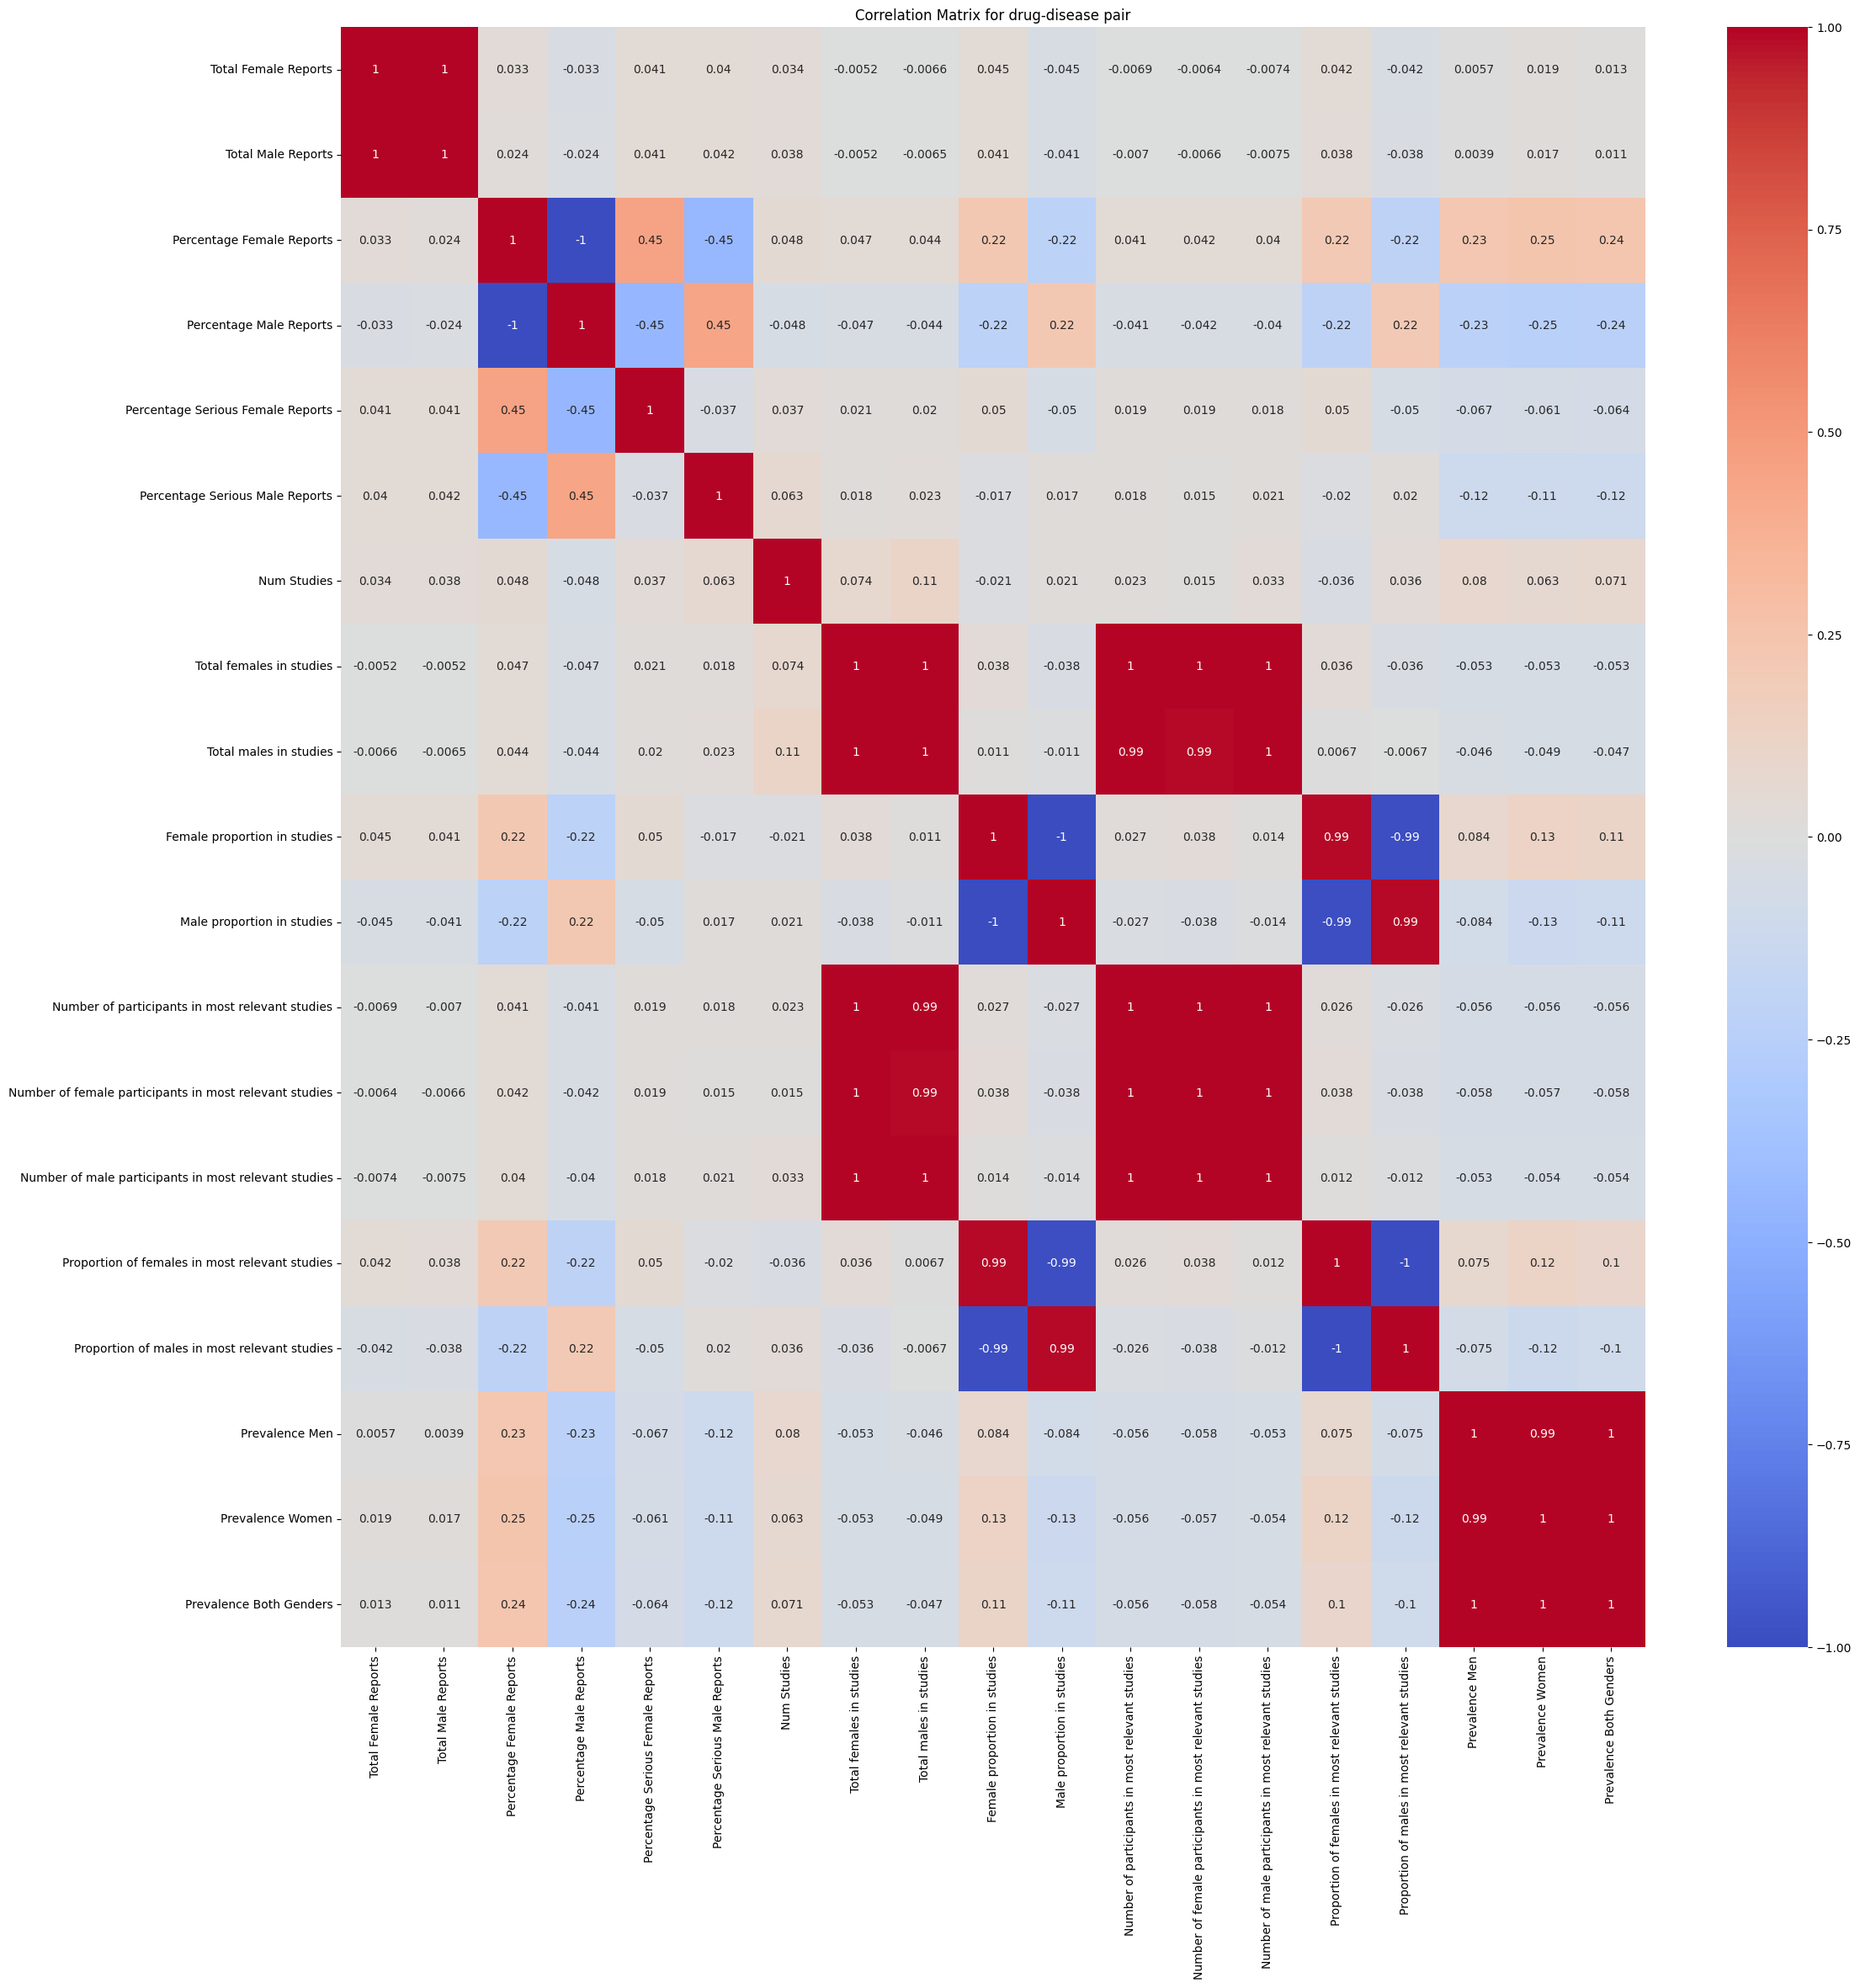

In [20]:
# Correlation matrix
matrix = data_df.drop(columns=['Indication', 'Drug', 'NCT Numbers', 'Most relevant studies', 'Top 5 Side Effects Female', 'Top 5 Side Effects Male'])
corr_matrix = matrix.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for drug-disease pair')
plt.show()